**Условие задачи**

На основании данных о пассажирах, которые воспользовались метро дважды за сутки, при наличии информации о первом заходе в метро, необходимо предсказать, на какой станции и через какой промежуток времени, этот пассажир воспользуется метро повторно. 


---


**Входные данные**

В данных присутствуют только те люди, которые совершили ровно две поездки в день, при этом статистика валидаций взята за несколько дней. 

**Описание столбцов**

*    id - уникальный идентификатор столбца; 
*   ticket_id - уникальный идентификатор билета, считается, что у одного билета один владелец
*   ticket_type_nm - тип билета 
*   entrance_id - уникальный id входа в станцию
*   entrance_nm - название
*   station_id - уникальное id станции захода 
*   station_nm - наименование станции захода 
*   line_id - уникальный id ветки на, которой находится станция
*   line_nm - наименование ветки, на которой находится станция 
*   pass_dttm - дата валидации 
*    time_to_under (столбец для предсказания) - сколько времени прошло между первой и второй валидацией
*   label (столбец для предсказания) - id второй станции, на которой
произошла валидация 

In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

**Датасет**

Подгружаем датасет

In [4]:
ds = pd.read_csv('/content/train_dataset_train.csv', sep = ',')

Хотим определить количество уникальных значений для каждой характеристики, а также тип данных для каждой из колонок

In [5]:
col = ds.columns
for item in col:
    print(f"Характеристика: {item}")
    print(f"Количество уникальных значений: {ds[item].nunique()}")
    print(f"{ds[item]}")
    print('--------------------------------------------')

Характеристика: id
Количество уникальных значений: 1091021
0                1
1                2
2                3
3                4
4                5
            ...   
1091016    1091017
1091017    1091018
1091018    1091019
1091019    1091020
1091020    1091021
Name: id, Length: 1091021, dtype: int64
--------------------------------------------
Характеристика: ticket_id
Количество уникальных значений: 335533
0          40BD89EC85646EFB69E283F39C298E60
1          126727A96489CC976A8C08E5CEB00542
2          D28CE6A9E0E5B6D213470A97CFF32485
3          015DA44B523C062B5BFEFF3FB0E64B9E
4          95B19C6F3A504727AC3EA56EB7E3E80F
                         ...               
1091016    6A738232F8E43DFCD4027FDC0EA6CC03
1091017    141174B366F14A8703903813A49374DB
1091018    E38493B30A7C55170806F187AF5EEA15
1091019    3DF2B6366631ECA06274DD2CB5B0DF24
1091020    80DA097A0BBFD91F5B15697AD53F8D3B
Name: ticket_id, Length: 1091021, dtype: object
--------------------------------------------
Харак

Определимся с категориальными признаками на основе данных выше и уберем ненужные столбцы (признаки)
Убираем столбцы, дублирующие информацию (ticket_id, entrance_id, line_id, station_id)
Также убираем entrance_nm, так как информация, лежащая в ней, уже содержится в station_nm
Убираем id, так как столбец не несет никакой информации

In [6]:
ds = ds.drop(['id', 'ticket_id', 'entrance_id', 'entrance_nm', 'line_id', 'station_id'], axis = 1)

На основе кода выше можем сказать, какие признаки ялвяются категориальнымии задим им тип category

In [7]:
ds.ticket_type_nm = pd.Series(ds.ticket_type_nm, dtype='category')
ds.line_nm = pd.Series(ds.line_nm, dtype='category')
ds.station_nm = pd.Series(ds.station_nm, dtype='category')

**Data Cleaning**

Найдем процент непустых объектов

In [8]:
values = ((ds.isna().sum() / len(ds)) * 100).sort_values()
count = 0

for i in values:
  if i == 0:
    count += 1

print(f'Количество полностью заполненных объектов - {count}')
print(f'Их процент из всей выборки - {int(count / len (values) * 100)}%')

Количество полностью заполненных объектов - 6
Их процент из всей выборки - 100%


Все столбцы заполнены полностью, пропусков нет.

Обработка выбросов

In [9]:
ds.time_to_under.describe()

count    1.091021e+06
mean     5.104668e+02
std      2.328452e+02
min      3.001667e+01
25%      3.229500e+02
50%      5.686833e+02
75%      6.838833e+02
max      1.437417e+03
Name: time_to_under, dtype: float64

Видим разброс в 2 порядка между минимальным и максимальным значениями времени между 2мя валидациями. Считаем их за выбросы

Выведем границы для нормальных значений времени между валидациями, используя интерквартильный размах. Посмотрим, входят ли минимальное и максимальное значения в интервал между полученными границами

In [10]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries

In [11]:
boundaries = calculate_outliers(ds.time_to_under)
boundaries

(-218.45, 1225.2833333333333)

In [12]:
if ds.time_to_under.max() < boundaries[1]:
    print('максимум входит в границы')
else:
    print('максимум не входит в границы')
    
if ds.time_to_under.min() > boundaries[0]:
    print('минимум входит в границы')
else:
    print('минимум не входит в границы')

максимум не входит в границы
минимум входит в границы


Посчитаем количество выбросов

In [13]:
is_outlier = (ds.time_to_under < boundaries[0]) | (ds.time_to_under > boundaries[1]) 
is_outlier.sum()

855

Какая это доля от всей выборки

In [14]:
is_outlier.sum() / len(ds.time_to_under)

0.0007836696085593219

Видим, что доля выбросов меньше 0,1% от всей выборки, поэтому просто уберем выбросы из датасета

In [15]:
ds = ds.loc[ds['time_to_under'] <= boundaries[1]]
print(ds.shape)

(1090166, 6)


**Data Visualization**

Построим гистограмму распределения времени между двумя последующими валидациями

Text(0, 0.5, 'Частота')

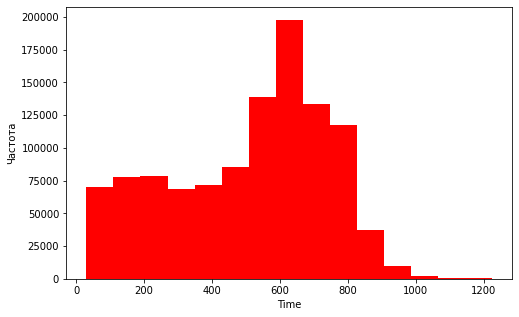

In [16]:
plt.figure(figsize=(8,5))
plt.hist(ds.time_to_under, bins=15, color='red')
plt.xlabel('Time')
plt.ylabel('Частота')

**Временной признак**

Разберемся со столбцом с временным типом данных. В нашем случае нам интересны день недели и час. Нам не интересно знать какой год и месяц (так как в выборке даны данные за 7 дней), также не интересны секунды и минуты

In [17]:
ds.pass_dttm = pd.to_datetime(ds.pass_dttm)
ds['hour'] = ds.pass_dttm.apply(lambda x: x.hour)
ds['dayofweek'] = ds.pass_dttm.dt.weekday
ds = ds.drop(['pass_dttm'], axis = 1)

**Data Visualization**

Построим зависимость времени между двумя последующими валидациями от часа и от дня недели

In [50]:
hours = np.arange(24)
number_of_validation = np.arange(24)
for item in range(0, 24):
  df = ds.loc[ds.hour == hours[item]]
  number_of_validation[item] = df.shape[0]

Text(0, 0.5, 'Number of people')

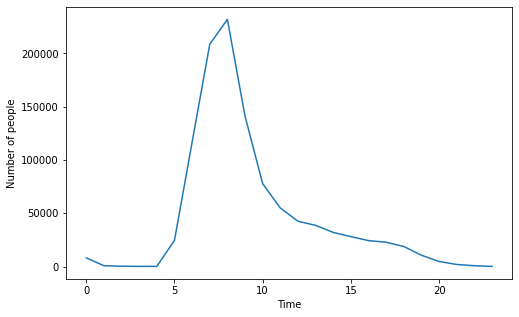

In [51]:
plt.figure(figsize=(8,5))
plt.plot(hours, number_of_validation)
plt.xlabel('Time')
plt.ylabel('Number of people')

In [52]:
weekdays = np.arange(7)
number_of_validation = np.arange(7)
for item in range(7):
  df = ds.loc[ds.dayofweek == weekdays[item]]
  number_of_validation[item] = df.shape[0]

number_of_validation

array([169081, 168942, 168451, 166489, 160737, 136643, 119823])

Text(0, 0.5, 'Number of people')

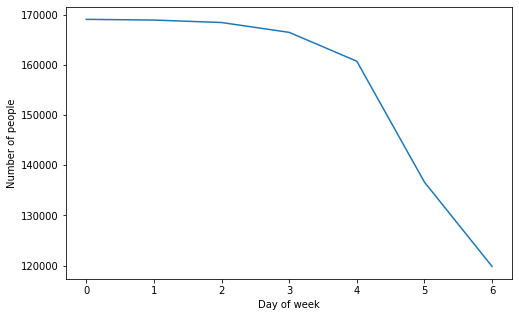

In [53]:
plt.figure(figsize=(8,5))
plt.plot(weekdays, number_of_validation)
plt.xlabel('Day of week')
plt.ylabel('Number of people')

**Преобразование категориальных переменных**

Хотим сделать датафрейм из 0 и 1, где 0 - True и 1 - False)))

Создадим новый датафрейм, содержащий только категориальные переменные

In [54]:
data = pd.DataFrame()
data = ds[['ticket_type_nm', 'station_nm', 'line_nm']]

Используем метод OneHotEncoder, чтобы преобразовать старый датафрейм в датафрейм из 0 и 1

In [55]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(data[['ticket_type_nm', 'station_nm', 'line_nm']])
ohe_model = ohe.transform(data[['ticket_type_nm', 'station_nm', 'line_nm']])

Добавляем преобразованные категориальные данные в исходный датафрейм

In [56]:
ds[ohe.get_feature_names()] = ohe_model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Чистим память (потому что не хватает)
Удаляем столбцы, дублирующие информацию

In [57]:
del data
del ohe
del ohe_model
del df
del hours
del weekdays
del number_of_validation
ds = ds.drop(['ticket_type_nm', 'station_nm', 'line_nm'], axis = 1)

Делим на обучающую и тестовыую выборки для задачи регрессии, предварительно уменьшив размер датасета практически вдвое (потому что не учит. Мб проблема переобучения)

In [58]:
from sklearn.model_selection import train_test_split
ds = ds.loc[ds.index < 500000]
x = ds.drop(columns = ['time_to_under', 'label'])
X_train, X_test, y_train, y_test = train_test_split(x, ds['time_to_under'], test_size=0.33, random_state=42)

Делаем предсказания для времени между 2 валидациями
В качестве модели используется модель Линейной регрессии

In [59]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

Займемся задачей классификации

Делаем тоже самое, что и для регрессии

In [60]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(x, ds['label'], test_size=0.33, random_state=42)

Делаем предсказания для станций (задача классификации)

Используем в качестве модели Гауссиан (потому что он один из немногих, кто смог достойно посчитать)

In [61]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_class, y_train_class)

GaussianNB()

Делаем предсказания по классам

In [62]:
y_pred_class = clf.predict(X_test_class)

Импортируем метрици для оценки модели

In [63]:
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

Считаем

In [64]:
0.5 * (r2_score(y_test, y_pred) + recall_score(y_test_class, y_pred_class, average='macro'))

0.25502315124560865